In [67]:
# this enable automatic reloading of libraries
%load_ext autoreload
%autoreload 2
from clib.bellhop import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
import warnings
warnings.filterwarnings(action='ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#bell = bellhop({'mediterrannee': '../SSP_4profils.mat'},name='cognac_cmap',rmax=100.)

---
## Linear chirp signal

In [255]:
f0 = 3000.   # central frequency (Hz)
T = 1.       # signal duration (s)
B = 500.     # bandwidth (Hz)
m = B / T
A = 1.       # amplitude 



###
fe = 2*(f0 + B/2.)  # fréquence d'échant. min
dt = 1/(fe*10.)

# signal definition : linear chirp 
t = np.arange(0.,60., dt)  #1.e-5 )    #fenetre de calcul    # 1.e-1/f0
t0 = 1.
s = A * np.sin (2.*np.pi * (f0 + m*(t-t0-T)/2.) * (t-t0)) * 0.
#s[np.where( (t<t0) | (t>T+t0))] = 0.
s[np.where(t==9.)]=1

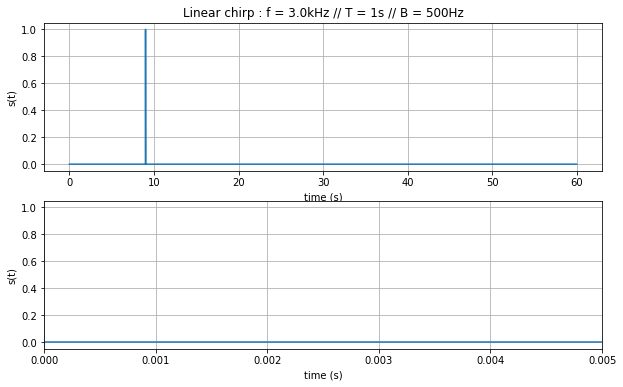

In [256]:
# plot temporal signal
plt.figure(figsize=(10,6))
plt.subplot(211)
plt.plot(t,s)
plt.title('Linear chirp : f = %.1fkHz // T = %ds // B = %dHz' %(f0/1000.,T,B))
plt.xlabel('time (s)')
plt.ylabel('s(t)')
plt.grid()

plt.subplot(212)
plt.plot(t,s)
plt.xlabel('time (s)')
plt.ylabel('s(t)')
plt.xlim([0.0,0.005])
plt.grid()
plt.show()

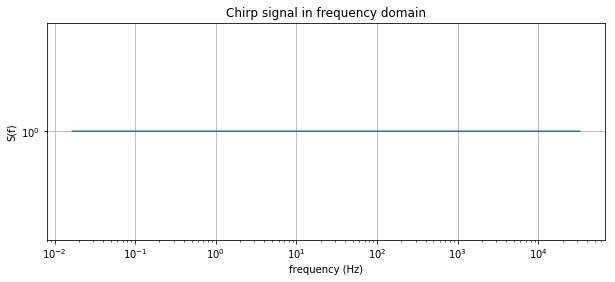

In [257]:
# Fourier transform
S = np.fft.fft(s)
freq = np.fft.fftfreq(t.shape[-1],d=t[1]-t[0])  # [0, 1/fenetre, 2/fenetre,.., Ni = 1/(2*dt), -Ni,.., -1/fenetre]
fig = plt.figure(figsize=(10,4))
ax = plt.subplot(111)
ip = np.where(freq>0)[0]
ax.plot(freq[ip], abs(S[ip]))
ax.set_yscale('log')
ax.set_xscale('log')
plt.title ('Chirp signal in frequency domain')
plt.xlabel('frequency (Hz)')
plt.ylabel('S(f)')
ax.grid()

---
## Signal reçu (signal parfait pour commencer) 

In [258]:
# signal temporel parfait :
#t = np.arange(0.,60., dt )    #fenetre de calcul    # 1.e-1/f0


t0 = 15.
s_out = A * np.sin (2.*np.pi * (f0 + m*(t-t0-T)/2.) * (t-t0)) *0.
#s_out[np.where( (t<t0) | (t>T+t0))] = 0.
s_out[np.where(t==17.)]=1

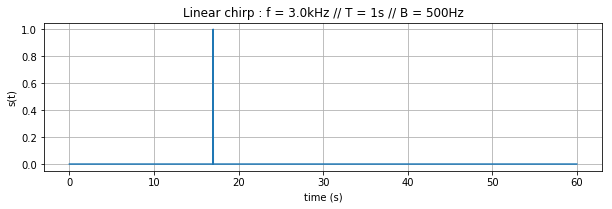

In [259]:
# plot temporal signal
plt.figure(figsize=(10,6))
plt.subplot(211)
plt.plot(t,s_out)
plt.title('Linear chirp : f = %.1fkHz // T = %ds // B = %dHz' %(f0/1000.,T,B))
plt.xlabel('time (s)')
plt.ylabel('s(t)')
plt.grid()

In [260]:
### Le temps d'arrivée exact du signal est 15s.

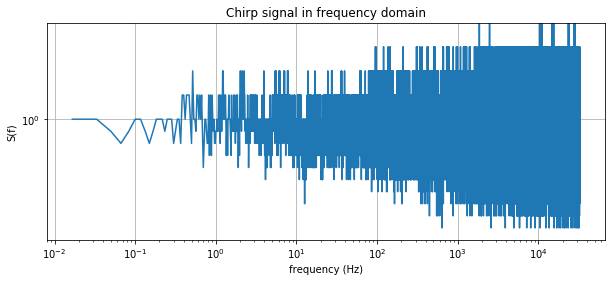

In [261]:
# Fourier transform
Sout = np.fft.fft(s_out)
#freq = np.fft.fftfreq(t.shape[-1],d=t[1]-t[0])  #[0, 1/fenetre, 2/fenetre,.., Ni = 1/(2*dt), -Ni,.., -1/fenetre]
fig = plt.figure(figsize=(10,4))
ax = plt.subplot(111)
ip = np.where(freq>0)[0]
ax.plot(freq[ip], abs(Sout[ip]))
ax.set_yscale('log')
ax.set_xscale('log')
plt.title ('Chirp signal in frequency domain')
plt.xlabel('frequency (Hz)')
plt.ylabel('S(f)')
ax.grid()

---
## Convolution 

In [262]:
Conv = Sout*S
Ifft = np.fft.ifft(Conv)

#plt.plot(t, np.real(Ifft), 'b')
#plt.plot(t, np.imag(Ifft), 'r')

Signal = np.abs(Ifft)

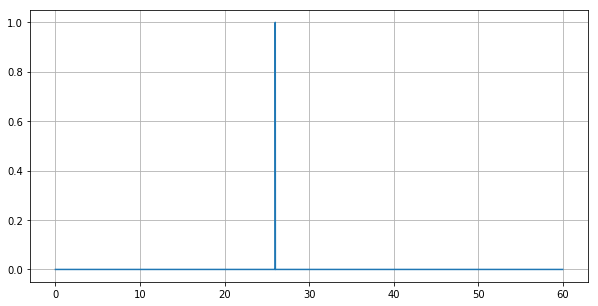

In [263]:
plt.figure(figsize=(10,5))
plt.plot(t, Signal)
#plt.xlim([12,18])
plt.grid()

In [264]:
t[np.where(Signal==np.max(Signal))][0]

26.0

In [183]:
t.size

3900000

In [184]:
Signal.size

3900000

In [291]:
t = np.arange(0.,60., dt)  #1.e-5 )    #fenetre de calcul    # 1.e-1/f0
t0 = 1.
s = A * np.sin (2.*np.pi * (f0 + m*(t-t0-T)/2.) * (t-t0)) * 0.
s_out = A * np.sin (2.*np.pi * (f0 + m*(t-t0-T)/2.) * (t-t0)) * 0.


s[np.where(t==35.)]=1.
s_out[np.where(t==43.)]=1.

S = np.fft.fft(s)
Sout = np.fft.fft(s_out)

Conv = Sout*S
Ifft = np.fft.ifft(Conv)
Signal = np.abs(Ifft)

t[np.where(Signal==np.max(Signal))][0]

18.0

In [124]:
### Seuil de détection 
# Comment fixer le seuil ? par rapport à quels critères ?

#seuil = 1.   
#tarr = t[np.where(Signal>seuil)[0][0]]
#tarr 

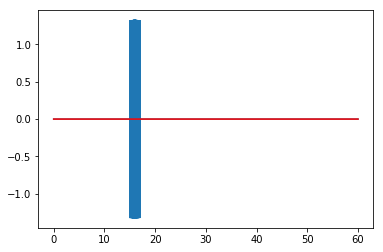

(12, 18)

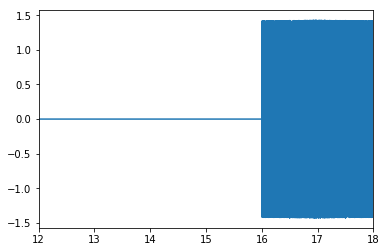

In [81]:
### Vérification du bon fonctionnement avec la méthode fftconvolve de scipy
Sortie = fftconvolve(s,s_out,mode='full')
plt.plot(np.arange(0.,Sortie.size)*dt,Sortie)
plt.xlim([12,18])

In [ ]:
#### Tester sur un vrai signal (convolution Tarr avec chirp)
#### Puis rajouter du bruit 